In [40]:
import lightgbm
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import random
import os

# 시드 고정 함수
def set_seed(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    
    lightgbm.seed = seed

set_seed(42)

In [52]:
import warnings

warnings.filterwarnings('ignore')

import pandas as pd

data = pd.read_csv('/Users/baby_cow/Desktop/AI/ML_competition/data/geocoded_addresses_12.csv')
data.columns

Index(['Unnamed: 0', '본번', '부번', '아파트명', '전용면적(㎡)', '계약년월', '계약일', '층', '건축년도',
       '도로명', '거래유형', 'k-전체동수', 'k-전체세대수', 'k-연면적', 'k-주거전용면적', 'k-관리비부과면적',
       'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하',
       'k-135㎡초과', '건축면적', '주차대수', 'target', 'is_test', 'latitude',
       'longitude', 'address', 'address_apt', 'address_apt_sqm', '구', '동',
       '강남여부', 'mean_target', 'apt_mean_target', 'address_mean_target',
       'mean_target_gu_dong', 'closest_bus_stop_distance',
       'closest_subway_station_distance', 'bus_stop_count_500m',
       'subway_station_count_500m', 'bus_stop_count_750m',
       'subway_station_count_750m', 'bus_stop_count_1000m',
       'subway_station_count_1000m', 'square_meter',
       'monthly_mean_target_rate', 'adjusted_square_meter', 'is_outlier',
       'year', 'month', 'distance_to_lead_house'],
      dtype='object')

In [42]:
temp_index = list(range(len(data)))
data['id'] = temp_index
selected_columns = ['id', '본번', '부번', '아파트명', '계약년월', '계약일', '층', '건축년도', '도로명',
        '거래유형', 'k-전체동수', 'k-전체세대수', 'k-연면적', 'k-주거전용면적', 'k-관리비부과면적',
        'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하',
        'k-135㎡초과', '건축면적', '주차대수', 'target', 'is_test', 'latitude',
        'longitude', '구', '동', 'closest_bus_stop_distance',
        'closest_subway_station_distance', 'bus_stop_count_500m',
        'subway_station_count_500m', 'bus_stop_count_750m',
        'subway_station_count_750m', 'bus_stop_count_1000m',
        'subway_station_count_1000m', 'is_outlier',
        'distance_to_lead_house', '전용면적']

df = data[selected_columns]

df['계약년'] = df['계약년월'].map(lambda x : int(str(x)[:4]))

# 지역별 chunk 나누기

In [43]:
chunks = {}

regions = df['구'].unique()

for region in regions:
    chunk = df[df['구'] == region]
    chunk.sort_values(by='계약년월')
    chunks[region] = chunk

# 올해 + 1년 전 우리 구 평균 부동산 가격 피쳐 만들기

In [44]:
from IPython.display import display
import numpy as np

for region in regions:
    chunk = chunks[region]

    year_target_means = {}

    for year in range(2007, 2024):
        this_year_target_mean = np.log(chunk.loc[(chunk['계약년'] == year) & (chunk['is_test'] == 0) ,'target'].mean())
        chunk.loc[(chunk['계약년'] == year) , '올해 지역 로그 평균'] =  this_year_target_mean
        year_target_means[year] = this_year_target_mean

        if year == 2007:
            chunk.loc[(chunk['계약년'] == year), '작년 지역 로그 평균'] = this_year_target_mean
        else:
            chunk.loc[(chunk['계약년'] == year), '작년 지역 로그 평균'] = year_target_means[year-1]
    
    chunks[region] = chunk

# log_mean_target 만들기

In [45]:
import numpy as np

for region in regions:
    chunk = chunks[region]

    for dong in chunk['동'].unique():
        dong_temp_df = chunk.loc[(chunk['is_test'] == 0) & (chunk['동'] == dong), :]
        chunk.loc[(chunk['동'] == dong), '동 로그 평균'] = np.log(dong_temp_df['target'].mean())

        for apart in dong_temp_df['아파트명'].unique():
            apart_temp_df = dong_temp_df.loc[(dong_temp_df['아파트명'] == apart), :]        
            chunk.loc[(chunk['동'] == dong) & (chunk['아파트명'] == apart), '아파트 로그 평균'] = np.log(apart_temp_df['target'].mean())

            for house in apart_temp_df['전용면적'].unique():
                house_temp_df = apart_temp_df.loc[(apart_temp_df['전용면적'] == house), :]
                chunk.loc[(chunk['동'] == dong) & (chunk['아파트명'] == apart) & (chunk['전용면적'] == house), '집 로그 평균'] = np.log(house_temp_df['target'].mean())

    

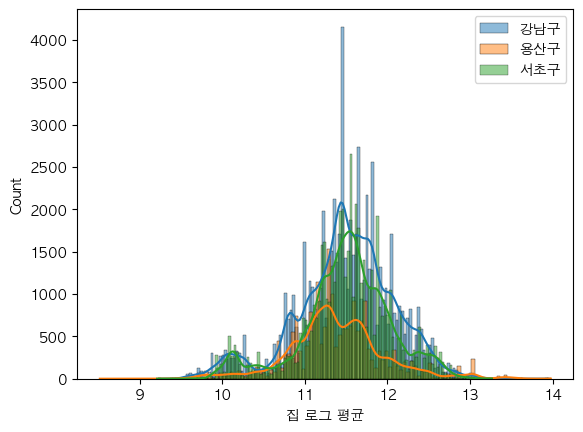

In [53]:
caution_regions = ['강남구', '용산구', '서초구']

for region in caution_regions:
    sns.histplot(data=chunks[region], x='집 로그 평균', kde=True, label = region)
plt.legend()

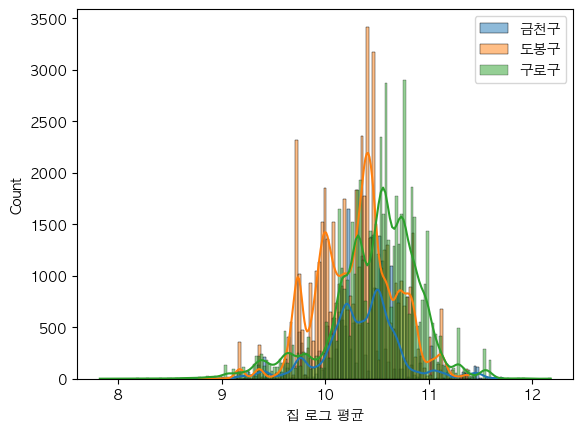

In [54]:
good_regions = ['금천구', '도봉구', '구로구']

for region in good_regions:
    sns.histplot(data=chunks[region], x='집 로그 평균', kde=True, label = region)
plt.legend()

# 모델 학습

In [47]:
import lightgbm as lgb
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from tqdm import tqdm

result_board = []
result = pd.DataFrame()

params = {
    'objective': 'regression', 
    'metric': 'rmse',           
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.1,
    'feature_fraction': 0.9,
    'lambda_l2' : 0.1,
    'drop_rate' : 0.2,
    'verbose' : -1
}

for region in tqdm(regions):
    chunk = chunks[region]

    select_cols = ['id', '본번', '부번', '계약일', '층', '건축년도',
        'k-전체동수', 'k-전체세대수', 'k-연면적', 'k-주거전용면적', 'k-관리비부과면적',
        'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하',
        'k-135㎡초과', '건축면적', '주차대수', 'target', 'is_test', 'latitude',
        'longitude', 'closest_bus_stop_distance',
        'closest_subway_station_distance', 'bus_stop_count_500m',
        'subway_station_count_500m', 'bus_stop_count_750m',
        'subway_station_count_750m', 'bus_stop_count_1000m',
        'subway_station_count_1000m',
        'distance_to_lead_house', '전용면적', '올해 지역 로그 평균', '작년 지역 로그 평균', '동 로그 평균', '아파트 로그 평균', '집 로그 평균',]
    
    chunk = chunk[select_cols]

    train_chunk = chunk.query('is_test == 0')
    test_chunk = chunk.query('is_test == 1')

    train_chunk.drop(columns=['is_test', 'id'], axis=1, inplace = True)
    test_chunk.drop(columns = ['is_test'], axis = 1, inplace = True)

    X = train_chunk.drop(columns=['target'], axis=1)
    y = train_chunk['target']

    tscv = TimeSeriesSplit(n_splits = 17)
    
    min_rmse = int(1e9)

    model = None
    for fold, (train_index, val_index) in enumerate(tscv.split(X), 1):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        train_data = lgb.Dataset(X_train, label = y_train)
        val_data = lgb.Dataset(X_val, label = y_val, reference = train_data)

        if model :
            model = lgb.train(
                params,
                train_data,
                num_boost_round=5000,
                init_model = model,
                valid_sets = [train_data, val_data],
                callbacks = [lgb.early_stopping(stopping_rounds=5), lgb.log_evaluation(period=-1)],
            )
        else:
            model = lgb.train(
                params,
                train_data,
                num_boost_round=5000,
                valid_sets = [train_data, val_data],
                callbacks = [lgb.early_stopping(stopping_rounds=5), lgb.log_evaluation(period=-1)],
            )
        y_pred = model.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        min_rmse = min(min_rmse, rmse)

    result_board.append({"지역" : region, "validation RMSE" : min_rmse})

    final_train_data = lgb.Dataset(X, label=y)
    final_model = lgb.train(params,
                            final_train_data,
                            init_model = model,
                            num_boost_round=model.best_iteration,
                            callbacks = [lgb.log_evaluation(period=-1)],
                            )

    test_X = test_chunk.drop(columns=['id', 'target'], axis=1)
    pred = final_model.predict(test_X)

    test_chunk['target'] = pred

    result = pd.concat([result, test_chunk[['id', 'target']]]) 


  0%|          | 0/25 [00:00<?, ?it/s]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[54]	training's rmse: 11022.3	valid_1's rmse: 42506.7
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[96]	training's rmse: 10631.4	valid_1's rmse: 15527.6
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[131]	training's rmse: 9991.83	valid_1's rmse: 70519.6
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[149]	training's rmse: 13076.3	valid_1's rmse: 42996.3
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[224]	training's rmse: 13362.7	valid_1's rmse: 28063.9
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[298]	training's rmse: 12540.6	valid_1's rmse: 36204.4
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[322]	t

  4%|▍         | 1/25 [00:13<05:33, 13.90s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[18]	training's rmse: 6345.5	valid_1's rmse: 15605.3
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[58]	training's rmse: 4014.37	valid_1's rmse: 7343.58
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[59]	training's rmse: 5119.66	valid_1's rmse: 23452.3
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[130]	training's rmse: 3778.35	valid_1's rmse: 22950.8
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[134]	training's rmse: 8284.48	valid_1's rmse: 18714.8
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[148]	training's rmse: 6394.69	valid_1's rmse: 9842.77
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[200]	tra

  8%|▊         | 2/25 [00:25<04:45, 12.42s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[60]	training's rmse: 2299.58	valid_1's rmse: 6281.57
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[109]	training's rmse: 2235.96	valid_1's rmse: 3093.61
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[111]	training's rmse: 2423.97	valid_1's rmse: 29562.4
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[138]	training's rmse: 2965.01	valid_1's rmse: 8743.71
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[141]	training's rmse: 4150.11	valid_1's rmse: 9893.02
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[142]	training's rmse: 5244.46	valid_1's rmse: 8507.9
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[159]	t

 12%|█▏        | 3/25 [00:29<03:12,  8.77s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[74]	training's rmse: 3410.04	valid_1's rmse: 10547.3
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[93]	training's rmse: 3661.23	valid_1's rmse: 5613.83
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[95]	training's rmse: 4120.84	valid_1's rmse: 34625.4
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[113]	training's rmse: 5437.13	valid_1's rmse: 9348.43
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[114]	training's rmse: 6237.89	valid_1's rmse: 7023.82
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[120]	training's rmse: 5651.22	valid_1's rmse: 10141.9
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[143]	tr

 16%|█▌        | 4/25 [00:40<03:17,  9.40s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[21]	training's rmse: 3761.04	valid_1's rmse: 8747.82
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[43]	training's rmse: 3156.35	valid_1's rmse: 4037.76
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[44]	training's rmse: 3392.05	valid_1's rmse: 35395.5
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[68]	training's rmse: 4096.12	valid_1's rmse: 9618.54
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[87]	training's rmse: 4117.37	valid_1's rmse: 9008.35
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[170]	training's rmse: 3646.65	valid_1's rmse: 8672.13
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[197]	trai

 20%|██        | 5/25 [00:48<02:59,  8.95s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[51]	training's rmse: 4854.99	valid_1's rmse: 17924.9
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[74]	training's rmse: 5327.33	valid_1's rmse: 7923.71
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[75]	training's rmse: 6166.2	valid_1's rmse: 44509.1
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[122]	training's rmse: 6427.13	valid_1's rmse: 22456
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[204]	training's rmse: 5997.19	valid_1's rmse: 13923.7
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[226]	training's rmse: 6309.96	valid_1's rmse: 17201.4
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[253]	train

 24%|██▍       | 6/25 [00:55<02:38,  8.36s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[71]	training's rmse: 2172.22	valid_1's rmse: 8668.63
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[124]	training's rmse: 2438.95	valid_1's rmse: 5507.07
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[152]	training's rmse: 2445.28	valid_1's rmse: 18222.1
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[207]	training's rmse: 2882.26	valid_1's rmse: 9769.08
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[253]	training's rmse: 3187.6	valid_1's rmse: 8438.74
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[342]	training's rmse: 3028.66	valid_1's rmse: 8485.24
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[361]	t

 28%|██▊       | 7/25 [01:08<02:56,  9.83s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[59]	training's rmse: 1733.36	valid_1's rmse: 6936.07
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[60]	training's rmse: 4623.81	valid_1's rmse: 11099.7
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[129]	training's rmse: 1859.25	valid_1's rmse: 12939.1
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[132]	training's rmse: 5330.01	valid_1's rmse: 8217.64
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[141]	training's rmse: 4030.49	valid_1's rmse: 6109.6
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[162]	training's rmse: 3296.42	valid_1's rmse: 4918.98
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[188]	tr

 32%|███▏      | 8/25 [01:14<02:25,  8.57s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[39]	training's rmse: 2380.61	valid_1's rmse: 7524.5
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[54]	training's rmse: 2670.99	valid_1's rmse: 3699.96
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[136]	training's rmse: 2119.28	valid_1's rmse: 32428.6
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[166]	training's rmse: 3094.61	valid_1's rmse: 10285.4
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[200]	training's rmse: 3198.87	valid_1's rmse: 8800.94
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[204]	training's rmse: 4085.72	valid_1's rmse: 5791.5
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[238]	tra

 36%|███▌      | 9/25 [01:25<02:31,  9.47s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[33]	training's rmse: 2125.96	valid_1's rmse: 6471.97
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[80]	training's rmse: 2038.76	valid_1's rmse: 5908.61
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[138]	training's rmse: 2043.77	valid_1's rmse: 11999
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[149]	training's rmse: 3771.02	valid_1's rmse: 9622.64
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[161]	training's rmse: 3827.89	valid_1's rmse: 8268.79
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[179]	training's rmse: 3552.36	valid_1's rmse: 4820.86
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[188]	tra

 40%|████      | 10/25 [01:33<02:14,  8.97s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[54]	training's rmse: 3538.44	valid_1's rmse: 7564.1
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[71]	training's rmse: 3474.8	valid_1's rmse: 6133.51
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[156]	training's rmse: 2785.17	valid_1's rmse: 18739.2
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[199]	training's rmse: 3659.06	valid_1's rmse: 9612.21
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[249]	training's rmse: 3958.91	valid_1's rmse: 9687.54
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[267]	training's rmse: 4193.98	valid_1's rmse: 7998.79
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[281]	tra

 44%|████▍     | 11/25 [01:42<02:04,  8.90s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[58]	training's rmse: 4485.52	valid_1's rmse: 12231.6
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[97]	training's rmse: 4364.66	valid_1's rmse: 6456.08
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[98]	training's rmse: 5056.85	valid_1's rmse: 51161.2
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[121]	training's rmse: 6676.77	valid_1's rmse: 12397.4
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[122]	training's rmse: 7951.76	valid_1's rmse: 10622.4
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[161]	training's rmse: 6050.42	valid_1's rmse: 12528
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[275]	trai

 48%|████▊     | 12/25 [01:52<01:59,  9.17s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[65]	training's rmse: 5469.42	valid_1's rmse: 13396.1
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[90]	training's rmse: 5747.21	valid_1's rmse: 6721.08
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[93]	training's rmse: 5781.76	valid_1's rmse: 46570.6
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[116]	training's rmse: 7338.33	valid_1's rmse: 13186.6
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[152]	training's rmse: 6673.68	valid_1's rmse: 14390
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[214]	training's rmse: 6056.9	valid_1's rmse: 12555.4
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[236]	train

 52%|█████▏    | 13/25 [02:02<01:54,  9.52s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[58]	training's rmse: 4523.92	valid_1's rmse: 8283.78
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[80]	training's rmse: 4027.62	valid_1's rmse: 7460.45
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[143]	training's rmse: 3417.53	valid_1's rmse: 21470
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[159]	training's rmse: 5379.61	valid_1's rmse: 11513.3
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[187]	training's rmse: 5001.29	valid_1's rmse: 9945.45
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[246]	training's rmse: 4537.26	valid_1's rmse: 9299.89
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[272]	tra

 56%|█████▌    | 14/25 [02:10<01:39,  9.04s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[41]	training's rmse: 11013.9	valid_1's rmse: 39424.4
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[100]	training's rmse: 9544.95	valid_1's rmse: 14593.7
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[101]	training's rmse: 11202.3	valid_1's rmse: 89075
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[115]	training's rmse: 16523.4	valid_1's rmse: 35031.4
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[127]	training's rmse: 16174.4	valid_1's rmse: 37173.6
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[141]	training's rmse: 15658.3	valid_1's rmse: 23708.6
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[158]	tr

 60%|██████    | 15/25 [02:18<01:28,  8.89s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[67]	training's rmse: 6447.09	valid_1's rmse: 15308.2
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[86]	training's rmse: 6334.93	valid_1's rmse: 5843.55
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[87]	training's rmse: 6064.9	valid_1's rmse: 72945.9
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[104]	training's rmse: 12643.1	valid_1's rmse: 21771.2
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[120]	training's rmse: 10996.7	valid_1's rmse: 18127.8
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[124]	training's rmse: 11393.9	valid_1's rmse: 12675.9
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[149]	tra

 64%|██████▍   | 16/25 [02:25<01:15,  8.38s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[70]	training's rmse: 3309.53	valid_1's rmse: 6653.48
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[91]	training's rmse: 3280.03	valid_1's rmse: 4753.5
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[118]	training's rmse: 3176.99	valid_1's rmse: 34681.1
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[139]	training's rmse: 4370.32	valid_1's rmse: 8434.45
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[140]	training's rmse: 5263.95	valid_1's rmse: 11457.1
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[211]	training's rmse: 3998.53	valid_1's rmse: 8882.12
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[271]	tr

 68%|██████▊   | 17/25 [02:36<01:12,  9.04s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[41]	training's rmse: 6641.98	valid_1's rmse: 25506.1
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[76]	training's rmse: 6253.69	valid_1's rmse: 9423.61
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[104]	training's rmse: 5779.78	valid_1's rmse: 33710.6
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[164]	training's rmse: 5964.73	valid_1's rmse: 31718.2
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[186]	training's rmse: 8275.25	valid_1's rmse: 30592.4
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[198]	training's rmse: 9231.87	valid_1's rmse: 15520.6
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[200]	t

 72%|███████▏  | 18/25 [02:49<01:12, 10.32s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[21]	training's rmse: 6883.7	valid_1's rmse: 14098.6
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[68]	training's rmse: 4296.1	valid_1's rmse: 8217.75
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[78]	training's rmse: 4774.67	valid_1's rmse: 25121
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[131]	training's rmse: 4349.75	valid_1's rmse: 18523
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[132]	training's rmse: 8634.79	valid_1's rmse: 12641.8
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[180]	training's rmse: 5472.38	valid_1's rmse: 13353.1
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[181]	training

 76%|███████▌  | 19/25 [02:59<01:01, 10.20s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[46]	training's rmse: 4405.53	valid_1's rmse: 13790.1
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[64]	training's rmse: 5213.09	valid_1's rmse: 7137.53
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[66]	training's rmse: 5648.79	valid_1's rmse: 47044.9
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[90]	training's rmse: 6680.38	valid_1's rmse: 13481.6
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[152]	training's rmse: 5870.73	valid_1's rmse: 11388.7
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[199]	training's rmse: 5595.36	valid_1's rmse: 13866
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[233]	train

 80%|████████  | 20/25 [03:12<00:55, 11.08s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[128]	training's rmse: 5714.84	valid_1's rmse: 72792.5
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[159]	training's rmse: 9410.81	valid_1's rmse: 18267.5
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[160]	training's rmse: 12416.6	valid_1's rmse: 89900.8
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[169]	training's rmse: 23365.8	valid_1's rmse: 43526.9
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[180]	training's rmse: 20222.6	valid_1's rmse: 16219.6
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[192]	training's rmse: 16767.4	valid_1's rmse: 19074.9
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[241]

 84%|████████▍ | 21/25 [03:22<00:42, 10.60s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[52]	training's rmse: 2731.21	valid_1's rmse: 8190.74
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[73]	training's rmse: 3237.49	valid_1's rmse: 5751.52
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[90]	training's rmse: 3151.6	valid_1's rmse: 20834.6
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[120]	training's rmse: 4042.43	valid_1's rmse: 8642.7
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[156]	training's rmse: 4194.81	valid_1's rmse: 9179.31
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[166]	training's rmse: 4385.72	valid_1's rmse: 8620.6
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[167]	train

 88%|████████▊ | 22/25 [03:35<00:34, 11.43s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[57]	training's rmse: 4035.8	valid_1's rmse: 11359
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[104]	training's rmse: 4607.57	valid_1's rmse: 11534.7
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[130]	training's rmse: 4900.27	valid_1's rmse: 34920.5
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[153]	training's rmse: 6735.74	valid_1's rmse: 16077.7
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[212]	training's rmse: 5752.14	valid_1's rmse: 14529.9
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[279]	training's rmse: 4713.33	valid_1's rmse: 13899.7
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[287]	tra

 92%|█████████▏| 23/25 [03:43<00:20, 10.25s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[32]	training's rmse: 4616.02	valid_1's rmse: 14338.7
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[48]	training's rmse: 6233.82	valid_1's rmse: 13077
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[56]	training's rmse: 7223.25	valid_1's rmse: 34577.1
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[123]	training's rmse: 7452.96	valid_1's rmse: 15091
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[204]	training's rmse: 6372.36	valid_1's rmse: 23262.5
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[263]	training's rmse: 5766.28	valid_1's rmse: 13615.9
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[318]	traini

 96%|█████████▌| 24/25 [03:52<00:09,  9.90s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[25]	training's rmse: 3164.53	valid_1's rmse: 5905.96
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[63]	training's rmse: 2361.01	valid_1's rmse: 6823.12
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[109]	training's rmse: 2282.29	valid_1's rmse: 12917
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[132]	training's rmse: 3253.32	valid_1's rmse: 8721.42
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[159]	training's rmse: 3361.91	valid_1's rmse: 6333.05
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[201]	training's rmse: 3076.29	valid_1's rmse: 5718.77
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[227]	tra

100%|██████████| 25/25 [04:07<00:00,  9.88s/it]


# 결과 확인

In [48]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 한글 폰트 설정
plt.rcParams['font.family'] = 'AppleGothic'  # MacOS의 기본 한글 폰트
plt.rcParams['axes.unicode_minus'] = False   # 마이너스 기호 깨짐 방지

4070.0642433740477


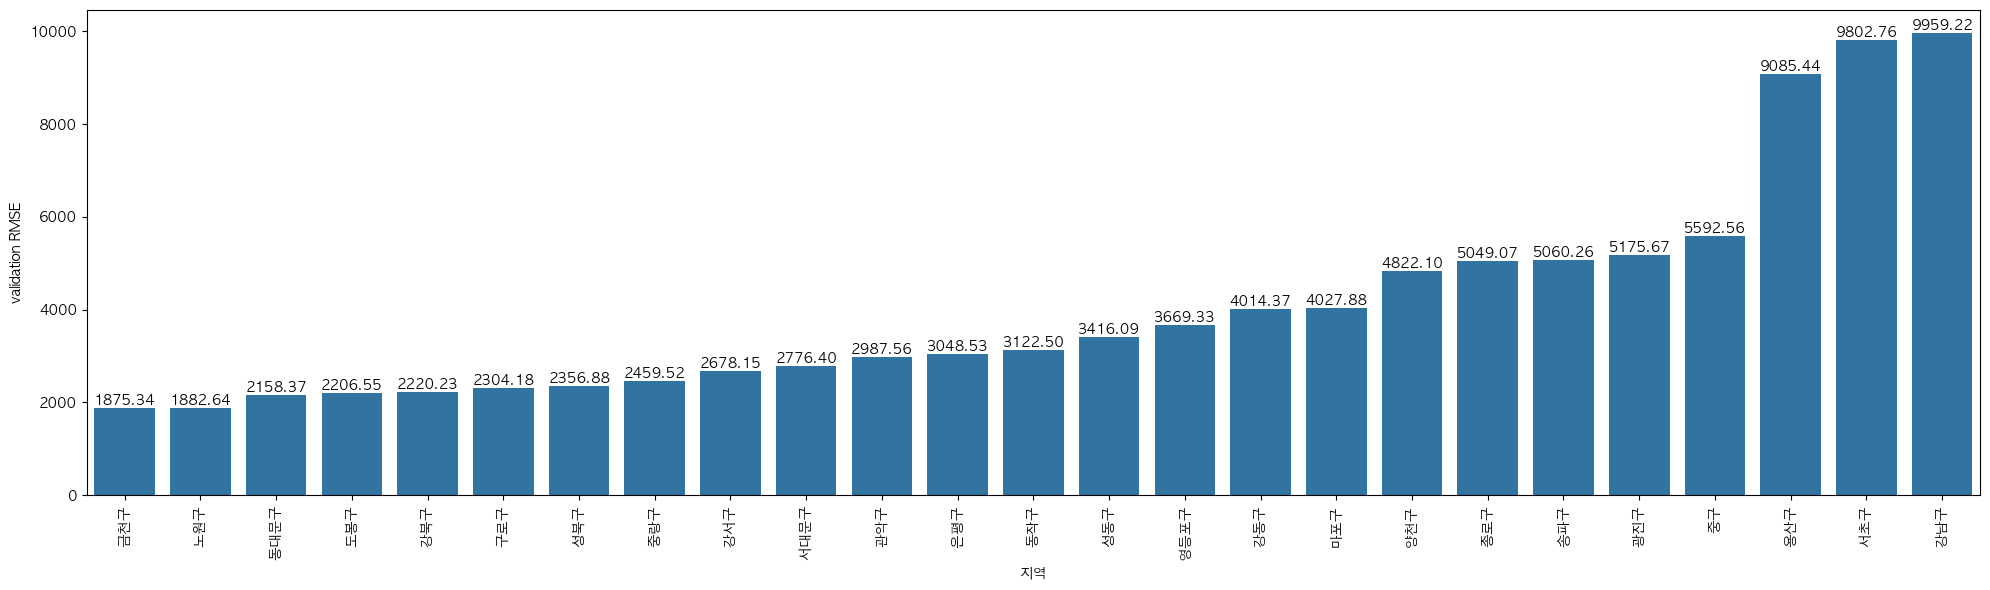

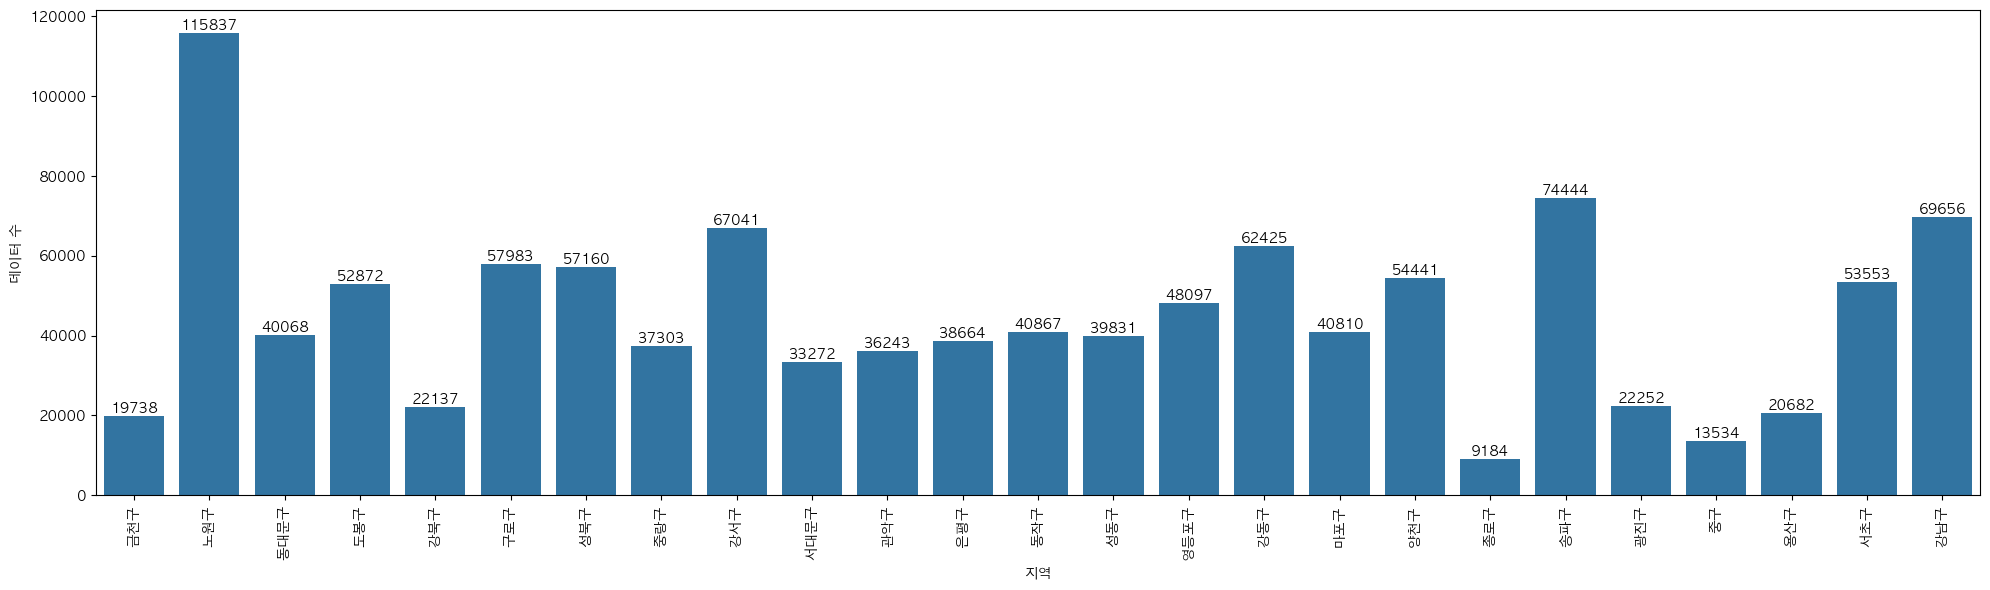

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

result_df = pd.DataFrame(result_board)
result_df = result_df.sort_values(by='validation RMSE')
result_df = result_df[-30:]

print(result_df['validation RMSE'].mean())

# 그래프 생성
plt.figure(figsize=(20, 6))
ax = sns.barplot(data=result_df, x='지역', y='validation RMSE')

# 바 위에 값 표시
for i, v in enumerate(result_df['validation RMSE']):
    ax.text(i, v, f'{v:.2f}', ha='center', va='bottom')

plt.xticks(rotation='vertical')
plt.tight_layout()
plt.show()

temp_list = [{"지역" : region, "데이터 수" : len(chunks[region])} for region in result_df['지역']]
temp_df = pd.DataFrame(temp_list)

plt.figure(figsize=(20, 6))
ax = sns.barplot(data = temp_df, x='지역', y='데이터 수')

# 바 위에 값 표시
for i, v in enumerate(temp_df['데이터 수']):
    ax.text(i, v, f'{v}', ha='center', va='bottom')

plt.xticks(rotation='vertical')
plt.tight_layout()
plt.show()

In [50]:
submit = result.sort_values(by = 'id')

display(submit)
print(submit.isnull().sum())

# submit['target'] = submit['target']  * 1.065
submit['target'] = submit['target'].astype(int)
submit.to_csv('region_devision_log_transform.csv', index=False)

,id,target
1118822,1118822,193856.910311
1118823,1118823,126967.487296
1118824,1118824,330073.526263
1118825,1118825,268601.030220
1118826,1118826,200997.479350
...,...,...
1128089,1128089,71883.653409
1128090,1128090,70786.701987
1128091,1128091,80633.424136
1128092,1128092,68888.718810


id        0
target    0
dtype: int64


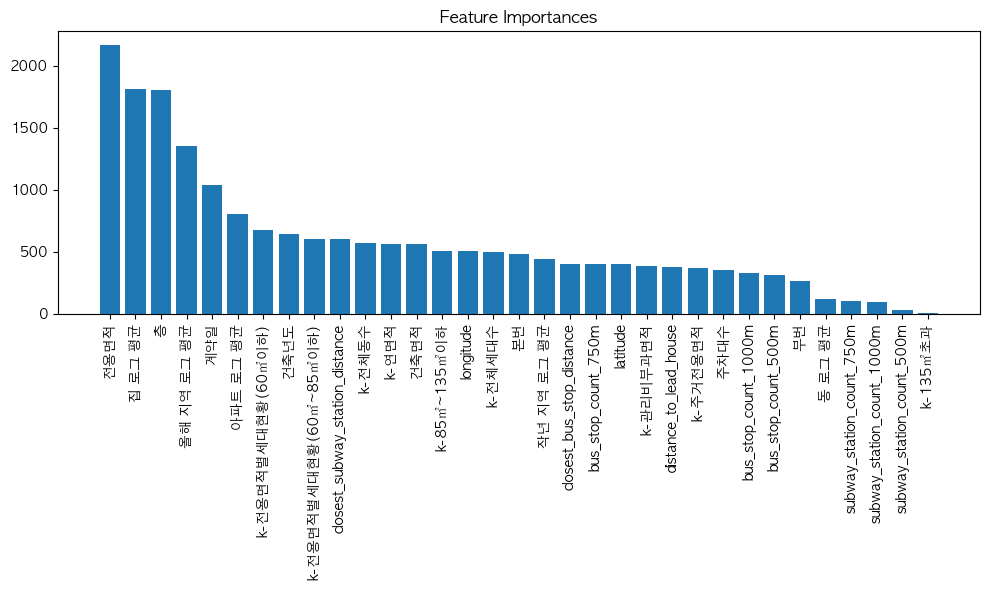

In [51]:
import matplotlib.pyplot as plt
import numpy as np

# 특성 중요도와 특성 이름 가져오기
importances = model.feature_importance()

feature_names = X.columns  # X는 특성 데이터프레임

# 중요도에 따라 특성 정렬
indices = np.argsort(importances)[::-1]

# 시각화
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(len(importances)), importances[indices])
plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=90)
plt.tight_layout()
plt.show()